In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from rdkit.Chem import Descriptors, rdmolops
import pickle
import sys
sys.path.append('../qmdesc')
from qmdesc.handler import ReactivityDescriptorHandler

In [2]:
#have to read the RDKit SMILES for index compatibility

df = pd.read_csv('ligand_data_final.csv')
df = df.loc[df['Hemilabile'] == False]

#Convert to Mol objects
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

labels = []
mol_ls = []
for i, x in tqdm(df.iterrows(), total=len(df)):
    try:
        mol = Chem.MolFromSmiles(x['SMILES_without_X_rdkit'])
        label_ls = [int(j) for j in x['Padded_catoms_rdkit'].strip('[]').replace(',', '').split()]
        mol_ls.append(mol)
        labels.append(label_ls)
    except:
        pass
len(mol_ls)

100%|██████████| 72585/72585 [00:20<00:00, 3543.45it/s]


72585

In [3]:
allowed_atoms = {1, 6, 7, 8, 9, 15, 16, 17, 35, 53} #H, C, N, O, F, P, S, Cl, Br, I
filtered_mol_ls = []
filtered_labels = []
num_failed = 0

#Filter: ensure atoms are those specified above, no radicals (RDKit kekulized correctly)
#Ensure no trivial (1-heavy-atom) ligands, no heavily charged ligands, and ligand size less than 50

for i in tqdm(range(len(mol_ls))):
    #Some of the mol objects fail to generate, skip over those here
    if mol_ls[i] is None:
        num_failed += 1
        continue
    atom_list = [a.GetAtomicNum() for a in mol_ls[i].GetAtoms()]
    if set(atom_list).issubset(allowed_atoms) and \
        Descriptors.NumRadicalElectrons(mol_ls[i]) == 0 and\
        len(atom_list) >= 2 and \
        Chem.GetFormalCharge(mol_ls[i]) <= 2 and Chem.GetFormalCharge(mol_ls[i]) >= -4 and \
        len(atom_list) <= 50:
        filtered_mol_ls.append(mol_ls[i])
        filtered_labels.append(labels[i])
len(filtered_mol_ls), num_failed

100%|██████████| 72585/72585 [00:08<00:00, 8156.91it/s]


(46719, 0)

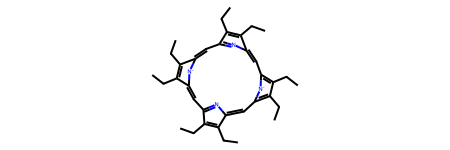

In [4]:
test = filtered_mol_ls[0]
test

In [5]:
test.GetNumAtoms()

40

In [7]:
len(results['partial_charge'])

40

In [6]:
handler = ReactivityDescriptorHandler()
results = handler.predict(Chem.MolToSmiles(test))
results

{'smiles': 'CCC1=C(CC)c2cc3[n-]c(cc4nc(cc5[n-]c(cc1n2)c(CC)c5CC)C(CC)=C4CC)c(CC)c3CC',
 'partial_charge': array([ 0.03270729,  0.03327773, -0.01462394, -0.01462394,  0.03327773,
         0.03270729,  0.0362875 , -0.01064982,  0.03729194, -0.21129224,
         0.03729195, -0.01064984,  0.03628749, -0.1471339 ,  0.03628749,
        -0.01064982,  0.03729194, -0.21129227,  0.03729195, -0.01064983,
         0.03628751, -0.1471339 , -0.00504876,  0.03791485,  0.03205629,
        -0.00504876,  0.03791486,  0.0320563 , -0.01462394,  0.03327772,
         0.03270728, -0.01462394,  0.03327771,  0.03270729, -0.00504874,
         0.03791486,  0.03205629, -0.00504876,  0.03791485,  0.0320563 ],
       dtype=float32),
 'fukui_neu': array([ 0.00393122,  0.00031168,  0.06010207,  0.06010207,  0.00031168,
         0.00393122,  0.02748289,  0.02088269,  0.01483827,  0.11349288,
         0.01483827,  0.02088268,  0.02748289,  0.04035588,  0.02748289,
         0.02088269,  0.01483827,  0.11349287,  0.01483